# Self-rag
I am following the notebook [here](https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_self_rag_local.ipynb).

![schematic of self-rag](graph_self_rag.png "Schematic of Self-Rag from [here](https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_self_rag_local.ipynb).")

In [1]:
# specify your working directory
working_dir = "/Users/pietromascheroni/open-modular-rag"
# specify the number of retrieved chunks
K = 5
# specify the number of maximum (query and answer) re-generations
N = 2

In [2]:
from dotenv import load_dotenv
import os
from langchain_chroma import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from torch import cuda
from typing import Callable
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
import chromadb

import pandas as pd
import re
import string

## Set up the retriever

In [3]:
embed_model_id = 'sentence-transformers/all-mpnet-base-v2'

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

# Initialize embedding model
embedding_model = HuggingFaceEmbeddings(
    model_name=embed_model_id,
    model_kwargs={'device': device},
    encode_kwargs={'device': device, 'batch_size': 32},
    cache_folder=working_dir + '/emb_model'
)

/Users/pietromascheroni/open-modular-rag/env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/pietromascheroni/open-modular-rag/env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
# ChromaDB setup to initilize collection including indeces of all documents
# (in case of errors, perform pip uninstall chromadb and pip install chromadb)
chroma_client = chromadb.PersistentClient(path=working_dir + "/vectordb")

In [5]:
# provide a name to setup and reference the vector index
collection_name = "more_agents_paper_self_rag"
# initialize the vector index with the respective similarity search metric
vectorstore = chroma_client.get_or_create_collection(collection_name, metadata={"hnsw:space": "cosine"})

In [6]:
print(f"We have {vectorstore.count()} chunks in the vector store")

We have 139 chunks in the vector store


In [7]:
emb_query = embedding_model.embed_documents(['LLM performance'])
output = vectorstore.query(query_embeddings=emb_query, n_results=5, include=['distances','documents'])
output['documents']

[['task designed to isolate each one. Consider the task detailed below: To start the analysis, we select two datasets with increasing difficulty, i.e., GSM8K and MATH, to calculate the rela- tive performance gain. The relative performance gain η is given by: η = Pm−Ps where Pm and Ps are the perfor- mances (accuracy) with our method and a single LLM query, respectively. The results are shown in',
  'based on Table 2. Task Llama2-13B Llama2-70B GPT-3.5-Turbo GSM8K (easy) MATH (hard) 69 200 37 120 16 34 It is noteworthy that the relative performance gain is more substantial with increasing task difficulty. Specifically, we observe that within the same task, the smaller model, Llama2-13B, gains ranging from 28%-200%, but only 8%- 16% over GPT-3.5-Turbo. Moreover, the more challenging task MATH',
  'for a given task. Nodes represent steps, while dashed lines indicate alternative potential steps. The depth of nodes represents the number of steps, and the color intensity represents the level

In [8]:
# Load the vectordb as a langchain object
langchain_chroma = Chroma(
    client=chroma_client,
    collection_name=collection_name,
    embedding_function=embedding_model,
)

print("There are", langchain_chroma._collection.count(), "in the langchain-formatted collection")

There are 139 in the langchain-formatted collection


In [9]:
retriever = langchain_chroma.as_retriever(
    search_kwargs={'k': K,
                   #'filter': {'Page': '1'}
                   }
    )

test_query = "LLM performance"
retriever.invoke(test_query)

[Document(page_content='task designed to isolate each one. Consider the task detailed below: To start the analysis, we select two datasets with increasing difficulty, i.e., GSM8K and MATH, to calculate the rela- tive performance gain. The relative performance gain η is given by: η = Pm−Ps where Pm and Ps are the perfor- mances (accuracy) with our method and a single LLM query, respectively. The results are shown in', metadata={'Last Modified': '2024-05-02T21:13:10', 'Page': '6', 'Source': '/Users/pietromascheroni/open-modular-rag/docs/2402.05120v1.pdf'}),
 Document(page_content='based on Table 2. Task Llama2-13B Llama2-70B GPT-3.5-Turbo GSM8K (easy) MATH (hard) 69 200 37 120 16 34 It is noteworthy that the relative performance gain is more substantial with increasing task difficulty. Specifically, we observe that within the same task, the smaller model, Llama2-13B, gains ranging from 28%-200%, but only 8%- 16% over GPT-3.5-Turbo. Moreover, the more challenging task MATH', metadata={'La

## LLMs

### Retrieval Grader

In [10]:
from langchain.prompts import PromptTemplate
from langchain_groq import ChatGroq
from langchain_core.output_parsers import JsonOutputParser
from dotenv import load_dotenv
import os

# Load environmental variables
load_dotenv()
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

# set up the LLM
llm = ChatGroq(temperature=0)

prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explaination.""",
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "more agents improve performance"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'score': 'yes'}


In [11]:
# # alternative initialization: this enforces directly the json format
# structured_llm = llm.with_structured_output(method="json_mode", include_raw=False)

# retrieval_grader_experimental = prompt | structured_llm
# print(retrieval_grader_experimental.invoke({"question": question, "document": doc_txt}))

### RAG generator

In [12]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

Yes, the documents suggest that using multiple agents can improve performance in certain tasks, as seen in the accuracy increase with ensemble size. Simply adding more instantiated LLM agents is reported to obtain a better LLM performance in processing complex tasks. However, it's important to note that input from multiple agents can sometimes disrupt coherence, leading to performance degradation.


In [13]:
# # To visualize the prompt template of rag
# print(prompt.messages[0].prompt.template)

### Hallucination grader

In [14]:

# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is grounded in / supported by a set of facts. \n 
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    Here is the answer: {generation}
    Give a binary score 'yes' or 'no' to indicate whether the answer is grounded in / supported by a set of facts. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})

{'score': 'yes'}

### Answer grader

In [15]:
# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is useful to resolve a question. \n 
    Here is the answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the question: {question}
    Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question, "generation": generation})

{'score': 'yes'}

### Question rewriter

In [16]:
# Prompt
re_write_prompt = PromptTemplate(
    template="""You are a question re-writer that converts an input question to a better version that is optimized for vectorstore retrieval. Look at the initial question and formulate an improved question. \n
     Here is the initial question: \n\n {question}. Improved question with no preamble: \n """,
    input_variables=["generation", "question"],
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'"Does increasing the number of agents lead to improved performance?"'

## Build the graph using Langgraph

### Initialize the graph state

In [17]:
from typing_extensions import TypedDict
from typing import List


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
        numque: number of re-generations of the query
        numans: number of re-generations of the answer
    """

    question: str
    generation: str
    documents: List[str]
    numque: int
    numans: int

### Nodes

In [18]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---NODE: RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---NODE: GENERATE---")
    question = state["question"]
    documents = state["documents"]
    numans = state["numans"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    numans += 1
    return {"documents": documents, "question": question, "generation": generation, "numans": numans}


def filter_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---NODE: FILTER FOR RELEVANCE---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        try:
            score = retrieval_grader.invoke( # added handling of exception (since we work with json output)
                {"question": question, "document": d.page_content}
            )
            grade = score["score"]
        except Exception as err:
            print("The error is:", err)
            grade == "N/A"
        if grade == "yes":
            print("-GRADE: DOCUMENT RELEVANT-")
            filtered_docs.append(d)
        elif grade == "no":
            print("-GRADE: DOCUMENT NOT RELEVANT-")
            continue
        else:
            print("An error occurred in filter_documents.")
    return {"documents": filtered_docs, "question": question, "generation": "N/A"}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---NODE: TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]
    numque = state["numque"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    numque += 1
    return {"documents": documents, "question": better_question, "numque": numque, "generation": "N/A"}

### Edges

In [19]:

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("--->ASSESS GRADED DOCUMENTS--->")
    question = state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered and no one was returned as relevant
        # We will re-generate a new query
        print(
            "--->DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO THE QUESTION, TRY TO TRANSFORM QUERY--->"
        )
        print("--->ASSESS NUMBER OF QUERY REGENERATIONS--->")
        numque = state["numque"]

        if numque <= N:
            print(f"--->DECISION: the number of regeneration is still below the threshold. We can continue.--->")
            return "transform_query"
        else:
            print(f"--->DECISION: the threshold for query regeneration was overcome. Exiting the loop.--->")
            return "rate_limited"

    else:
        # We have relevant documents, so generate answer
        print("--->DECISION: GENERATE--->")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("--->CHECK HALLUCINATIONS--->")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    try:
        score = hallucination_grader.invoke(
            {"documents": documents, "generation": generation}
        )
        grade = score["score"]
    except Exception as err:
        print("The error is:", err)
        grade == "N/A"
    # Check hallucination
    if grade == "yes":
        print("--->DECISION: GENERATION IS GROUNDED IN DOCUMENTS--->")
        # Check question-answering
        print("--->GRADE GENERATION vs QUESTION--->")
        try:
            score = answer_grader.invoke({"question": question, "generation": generation})
            grade = score["score"]
        except Exception as err:
            print("The error is:", err)
            grade == "N/A"
        if grade == "yes":
            print("--->DECISION: GENERATION ADDRESSES QUESTION--->")
            return "useful"
        elif grade == "no":
            print("--->DECISION: GENERATION DOES NOT ADDRESS QUESTION--->")
            print("--->ASSESS NUMBER OF QUERY REGENERATIONS--->")
            numque = state["numque"]

            if numque <= N:
                print("DECISION: the number of query regeneration is still below the threshold. We can continue.")
                return "not useful"
            else:
                print("DECISION: The threshold for query regenerations was overcome. Exiting the loop.")
                return "rate_limited"

        else:
            print("An error occured in the answer_grader inside the hallucination grader")

    elif grade == "no":
        print("--->DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS--->")
        print("--->ASSESS NUMBER OF ANSWER REGENERATIONS--->")
        numans = state["numans"]
        if numans <= N:
            print("DECISION: the number of answer regenerations is still below the threshold. We can continue.")
            return "not supported"
        else:
            print("DECISION: The threshold for query regenerations was overcome. Exiting the loop.")
            return "rate_limited"
    else:
        print("An error occured in the hallucination grader")
        return "not supported"

### Build the graph

In [20]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve) 
workflow.add_node("filter_documents", filter_documents)  
workflow.add_node("generate", generate)  
workflow.add_node("transform_query", transform_query)

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "filter_documents")
workflow.add_conditional_edges(
    "filter_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
        "rate_limited": END
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
        "rate_limited": END
    },
)

# Compile
app = workflow.compile()

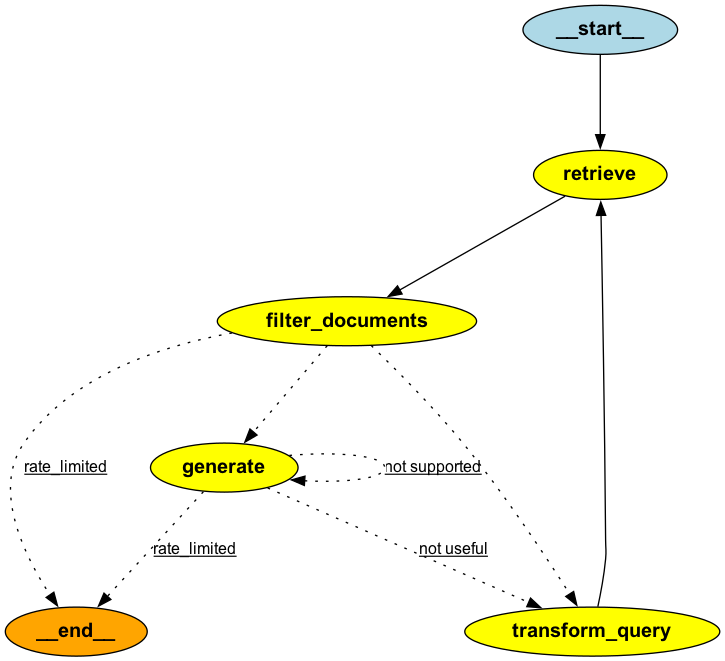

In [36]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_png()))
except:
    # This requires some extra dependencies and is optional
    print("doh")
    pass

### Run the self rag over the graph

In [22]:
from pprint import pprint

# Run
inputs = {"question": "Explain how performance changes with the number of agents.", "numque": 0, "numans": 0}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        pprint(value, indent=2, width=80, depth=None)
    print("\n---------\n")

# Final generation
pprint(value["generation"])

---NODE: RETRIEVE---
"Node 'retrieve':"
{ 'documents': [ Document(page_content='we can no- tice the effects of putting multiple agents together, to some extent, can lead to a performance improvement in certain problems. For example, in Table 10 of Section 3.3 of LLM- Equal contribution 1Tencent Inc. Correspondence to: Deheng Ye <dericye@tencent.com>. Figure 1. The accuracy increases with ensemble size across Llama2-13B, Llama2-70B and GPT-3.5-Turbo in GSM8K. When the', metadata={'Last Modified': '2024-05-02T21:13:10', 'Page': '1', 'Source': '/Users/pietromascheroni/open-modular-rag/docs/2402.05120v1.pdf'}),
                 Document(page_content='than the relationship between the number of agents and performance. We also select representative methods (Du et al., 2023; Shinn et al., 2023) to combine with our method, achieving further enhancements. 3. Method Tasks Our method is evaluated on the following task: In this section, we introduce our method which is imple- mented through a two-

In [23]:
# Run
inputs = {"question": "How does memory work for agents?", "numque": 0, "numans": 0}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        pprint(value, indent=2, width=80, depth=None)
    print("\n---------\n")

# Final generation
pprint(value["generation"])

---NODE: RETRIEVE---
"Node 'retrieve':"
{ 'documents': [ Document(page_content='al., 2023). Liu et al. (2023) enables agents to interact for multiple rounds in a dynamic architecture. Li et al. (2023a); Hong et al. (2023); Wu et al. (2023); Chen et al. (2023c;a) offer several multi-agent frameworks that enable the development of LLM applications or enhance task-solving capabilities. However, these methods primarily 2', metadata={'Last Modified': '2024-05-02T21:13:10', 'Page': '2', 'Source': '/Users/pietromascheroni/open-modular-rag/docs/2402.05120v1.pdf'}),
                 Document(page_content='for llm agents: A social psychology view. arXiv preprint arXiv:2310.02124, 2023. Zhao, W. X., Zhou, K., Li, J., Tang, T., Wang, X., Hou, Y., Min, Y., Zhang, B., Zhang, J., Dong, Z., Du, Y., Yang, C., Chen, Y., Chen, Z., Jiang, J., Ren, R., Li, Y., Tang, X., Liu, Z., Liu, P., Nie, J.-Y., and Wen, J.-R. A survey of large language models. arXiv preprint arXiv:2303.18223, 2023. 11', metadata={'Las